# **US Foods - Restaurants Data Extraction and Preparation**

This notebook will walk you through the process of extracting restaurants data like name, address, city, state, zipcode, latitude & longitude, ratings, cuisines etc. through different APIs and web scraping. 

This extracted data is then processed to structured format which can be used for Analytical Consumption

***Contents***

1. Code to Extract Data from Yelp API and Website Scraping
2. Tabular Format Representation of Data Collected from Yelp 
3. Code to Extract Data from Other Resources
4. Data Prepartion for Analytical Consumption 
5. EDA

## **1. Code to Extract Data from Yelp API and Website Scraping**

Yelp has different APIs for different purpose. For our problem statement we will be using two APIs - Business Search API and Business Details API.

Business Search API is used to get the details of restaurants present in the given search location.

Business Details API is used to get the details of the specific restaurant by pasing the Business ID obtained from the Business Search API

*Reference* - [LINK](https://www.yelp.com/developers/documentation/v3/business)

***Code Flow***

1. Pass the SEARCH LOCATION ex. San Francisco etc. and SEARCH TERM ie 'food' in the defaults section
2. Send GET request to the Business Search API passing location and term
3. Pass each Business ID present in the response of the step 2 in GET request to Business Details to obtain details of restaurants
4. End output is JSON response which contains restaurant information like name, address, latitude, longitude, ratings, cuisine etc


In [1]:
# import required packages

from __future__ import print_function
import argparse
import json
import pprint
import requests
import sys
import urllib
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import preprocessing

# This client code can run on Python 2.x or 3.x.  Your imports can be
# simpler if you only need one of those.
try:
    # For Python 3.0 and later
    from urllib.error import HTTPError
    from urllib.parse import quote
    from urllib.parse import urlencode
except ImportError:
    # Fall back to Python 2's urllib2 and urllib
    from urllib2 import HTTPError
    from urllib import quote
    from urllib import urlencode

# import required packages for web scraping
from bs4 import BeautifulSoup
import requests
import csv
import pandas as pd
import re

# import packages required for scraping google search ui
!pip install google-search-results
from serpapi.google_search_results import GoogleSearchResults

ERROR: Error checking for conflicts.
Traceback (most recent call last):
  File "c:\users\manohar\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "c:\users\manohar\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\users\manohar\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3012, in _parsed_pkg_info
    return self._pkg_info
  File "c:\users\manohar\anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _pkg_info

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\users\manohar\anaconda3\lib\site-packages\

In [2]:
# Yelp uses private keys to authenticate requests (API Key)
# You can find it on https://www.yelp.com/developers/v3/manage_app

# Set API Key

API_KEY= "J_1E_bEc08K-fNoQbmx7DTQfX50W0xGM5ZssMBTKEkQ3FANNisiY5KqxPTMCAdFSyeCkMhOKOHYWzlyMPS4iExVfNzP4mfH30ApICsVK2OTyPz_baSJ5wMcyqweAX3Yx" 


In [3]:
# API constants, you shouldn't have to change these.

API_HOST = 'https://api.yelp.com'
SEARCH_PATH = '/v3/businesses/search'
BUSINESS_PATH = '/v3/businesses/'  # Business ID will come after slash.
REVIEWS_PATH = '/reviews'   # This will come after Business ID


In [4]:
# Function for Yelp Web Scraping

def getAndParseURL(url): 
  ''' Send url of the site to be parsed

      Input : url of the site
      Output : parsed html '''

  try:
    result = requests.get(url)
    soup = BeautifulSoup(result.text, 'html.parser')
    return(soup)
  except:
    print("URL Not Accessible")

In [5]:
# Functions for Yelp API

def request(host, path, api_key, url_params=None):
    """Given your API_KEY, send a GET request to the API.
    Args:
        host (str): The domain host of the API.
        path (str): The path of the API after the domain.
        API_KEY (str): Your API Key.
        url_params (dict): An optional set of query parameters in the request.
    Returns:
        dict: The JSON response from the request.
    Raises:
        HTTPError: An error occurs from the HTTP request.
    """
    url_params = url_params or {}
    url = '{0}{1}'.format(host, quote(path.encode('utf8')))
    headers = {
        'Authorization': 'Bearer %s' % api_key,
    }

    response = requests.request('GET', url, headers=headers, params=url_params)

    return response.json()


def search(api_key, term, location):
    """Query the Search API by a search term and location.
    Args:
        term (str): The search term passed to the API.
        location (str): The search location passed to the API.
    Returns:
        dict: The JSON response from the request.
    """

    url_params = {
        'term': term.replace(' ', '+'),
        'location': location.replace(' ', '+'),
        'limit': SEARCH_LIMIT
    }
    return request(API_HOST, SEARCH_PATH, api_key,url_params)


def get_business(api_key, business_id):
    """Query the Business API by a business ID.
    Args:
        business_id (str): The ID of the business to query.
    Returns:
        dict: The JSON response from the request.
    """
    business_path = BUSINESS_PATH + business_id

    return request(API_HOST, business_path, api_key)
    
    
def get_reviews(api_key, business_id):
    """Query the Reviews API by a business ID.
    Args:
        business_id (str): The ID of the business to query.
    Returns:
        dict: The JSON response from the request.
    """
    reviews_path = BUSINESS_PATH + business_id + REVIEWS_PATH

    return request(API_HOST, reviews_path, api_key)


def query_api(term, location):
    """Queries the API by the input values from the user.
    Args:
        term (str): The search term to query.
        location (str): The location of the business to query.
    """
    response = search(API_KEY, term, location)

    businesses = response.get('businesses')
    
    print("Found total {} restuarants\n-----------********------------".format(len(businesses))) # Prints no.of restaurants data found in response

    if not businesses:
        print(u'No businesses for {0} in {1} found.'.format(term, location))
        return

    api_result = [] # stores the json response of pi

    for i in range(len(businesses)):
        business_id = businesses[i]['id']
        
        business_response = get_business(API_KEY, business_id)
        # reviews_response = get_reviews(API_KEY, business_id) # use if you want to extract reviews

        api_result.append(business_response) # append response to list

    # print result of one restaurant
    print("Sample JSON response of one restaurant\n")
    pprint.pprint(api_result[0], indent=3)

    # store result in json
    import json
    with open('yelp_sf_13_10_2020.json', 'w') as fout:
        json.dump(api_result, fout)


def main():

    try:
        query_api(DEFAULT_TERM, DEFAULT_LOCATION)
    except HTTPError as error:
        sys.exit(
            'Encountered HTTP error {0} on {1}:\n {2}\nAbort program.'.format(
                error.code,
                error.url,
                error.read(),
            )
        )


In [6]:
# Defaults for our simple example.
DEFAULT_TERM = 'food'
DEFAULT_LOCATION = 'San Francisco, CA'
SEARCH_LIMIT = 50

main() # call the function

Found total 50 restuarants
-----------********------------
Sample JSON response of one restaurant

{  'alias': 'tacorea-chinatown-san-francisco',
   'categories': [  {'alias': 'mexican', 'title': 'Mexican'},
                    {'alias': 'korean', 'title': 'Korean'},
                    {'alias': 'latin', 'title': 'Latin American'}],
   'coordinates': {'latitude': 37.797972, 'longitude': -122.407453},
   'display_phone': '(415) 506-9642',
   'hours': [  {  'hours_type': 'REGULAR',
                  'is_open_now': False,
                  'open': [  {  'day': 1,
                                'end': '1430',
                                'is_overnight': False,
                                'start': '1130'},
                             {  'day': 1,
                                'end': '2000',
                                'is_overnight': False,
                                'start': '1700'},
                             {  'day': 2,
                                'end': '1430

## **2. Data Preparation from Yelp API response**

Fron the JSON we got from step 1 we are gooing to create a dataframe which stores the following fields data

* name ------------- Name of the Restaurant
* city ----------------- Restaurant city
* state --------------- Restaurant state
* latitude ------------ Latitude of restaurant
* longitude --------- Longitude of restaurant
* zipcode ------------ Zipcode of restaurant
* price ----------------- Price category of restaurant
* hours ---------------- Restaurant operating hours in the form of dictionary
* transactions ----- Restaurant transaction type (any type - pickup, delivery, restaurant_reservation)
* categories -------- Restaurant cuisine
* ratings -------------- Restaurant rating in the scale of 1 - 5
* reviews_count --- Count of ratings of the restaurant
* url----------------------- Yelp url of the restaurant

New columns are also created which are:
* distance ------------- Distance of the restaurant fron the city center
* reviews_count_bin ---- Converting continuous values of reviews_count column to bins
* distance_bins ---- Converting continuous values of distance column to bins



In [7]:
# code to parse response of each restaurant api

import json

# read json file which is created in previous step
with open('yelp_sf_13_10_2020.json') as f:
  data = json.load(f)

data_rows = [] # list to store data fields

for i in range(len(data)): # iterate over all responses in JSON file
# for i in range(3):

  business_details = data[i] # response of each restaurant

  try:
    ''' latitude of the restaurant'''

    latitude = business_details['coordinates']['latitude']
  except:
    latitude = 0
  
  try:
    ''' longitude of the restaurant'''

    longitude = business_details['coordinates']['longitude']
  except:
    longitude = 0

  try:
    ''' zipcode of the restaurant'''

    zipcode = business_details['location']['zip_code']
  except:
    zipcode = 0

  try:
    ''' city of the restaurant'''

    city = business_details['location']['city']
  except:
    city = 'N/A'

  try:
    ''' state of the restaurant'''

    state = business_details['location']['state']
  except:
    state = 'N/A'
  
  try:
    ''' yelp url of the restaurant'''

    url = business_details['url']
  except:
    url = 'N/A'


  try:
    ''' name of the restaurant'''

    name = business_details['name']
  except:
    name = 'N/A'

  try:
    ''' yelp rating of the restaurant'''

    ratings = business_details['rating']
  except:
    ratings = 0

  try:
    ''' count of reviews of the restaurant'''

    review_count = business_details['review_count']
  except:
    review_count = 0

  try:
    ''' Type of restaurant ie. pickup, delivery or restaurant_reservation'''

    transactions = business_details['transactions']
  except:
    transactions = 'N/A'

  try:
    ''' Cuisine of the restaurant'''

    categories = [k['title'] for k in business_details['categories']]
  except:
    categories = 'N/A'
  
  try:
    ''' Operating hours of the restaurant'''

    hours = business_details['hours'][0]['open']
  except:
    hours = 'N/A'

  try:
    ''' Categorical price of the restaurant - $, $$, $$$, $$$$, $$$$$'''

    price = business_details['price']
  except:
    price = 'N/A'

  # Call scrape function to extract written reviews and count
  soup = getAndParseURL(url)
    
  try:
      written_reviews = [i.find('span').text for i in soup.find_all('p', class_ = 'lemon--p__373c0__3Qnnj text__373c0__2Kxyz comment__373c0__3EKjH text-color--normal__373c0__3xep9 text-align--left__373c0__2XGa-')]
      written_reviews_count = len(written_reviews)
  except:
      written_reviews = []
      written_reviews_count = len(written_reviews)

  data_rows.append([name,city,state,zipcode,latitude,longitude,price,hours,transactions,categories,ratings,review_count,url,written_reviews,written_reviews_count]) # append to list

# create dataframe
df = pd.DataFrame(data_rows, columns = ['name','city','state','zipcode','latitude','longitude','price','hours','transactions','categories','ratings','review_count','url','written_reviews','written_reviews_count'])


In [8]:
''' Functions to calculate distance of each restaurant from city center'''

def degree_to_radion(degree):
    return degree*(np.pi/180)

def calculate_distance(store_latitude, store_longitude, postal_code_latitude, postal_code_longitude):
    
    from_lat = degree_to_radion(store_latitude)
    from_long = degree_to_radion(store_longitude)
    to_lat = degree_to_radion(postal_code_latitude)
    to_long = degree_to_radion(postal_code_longitude)
    
    radius = 6371.01
    
    lat_diff = to_lat - from_lat
    long_diff = to_long - from_long

    a = np.sin(lat_diff / 2)**2 + np.cos(degree_to_radion(from_lat)) * np.cos(degree_to_radion(to_lat)) * np.sin(long_diff / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return radius * c

In [9]:
''' Functions to convert continuos values of passed columns to bins'''

def convert_distance_2_bins(column):
    converted = []
    for i in column:
        if 0<=round(i,1)<=2.5:
            converted.append('In_city')
        elif 2.5<round(i,1)<=5:
            converted.append('Within_city')
        else:
            converted.append('Outskirts')
    return converted

def convert_review_count_2_bins(column):
    converted = []
    for i in column:
        if 0<=i<=500:
            converted.append('Low_count_reviews')
        elif 500<i<=2000:
            converted.append('Mid_count_reviews')
        else:
            converted.append('High_count_reviews')
    return converted

In [10]:
# clean values : remove extra spaces
df['categories'] = [[val.strip() for val in sublist] for sublist in df['categories'].values]

# create new column of distance of each restaurant from city center
df['distance'] = calculate_distance(37.7749,-122.4194, df.latitude, df.longitude) * 0.621371

# create new columns for review count and distance which stores in values
df['review_count_bins'] = convert_review_count_2_bins(df['review_count'])
df['distance_bins'] = convert_distance_2_bins(df['distance'])

df.head(3)

,name,city,state,zipcode,latitude,longitude,price,hours,transactions,categories,ratings,review_count,url,written_reviews,written_reviews_count,distance,review_count_bins,distance_bins
0,Tacorea - Chinatown,San Francisco,CA,94133,37.797972,-122.407453,N/A,"[{'is_overnight': False, 'start': '1130', 'end...",[],"[Mexican, Korean, Latin American]",4.5,11,https://www.yelp.com/biz/tacorea-chinatown-san...,"[Few things.. If you're a native, then know th...",11,1.795138,Low_count_reviews,In_city
1,Hot Sauce and Panko,San Francisco,CA,94109,37.794505,-122.417957,$$,"[{'is_overnight': False, 'start': '1130', 'end...","[delivery, pickup]","[Chicken Wings, Waffles, Sandwiches]",4.5,1158,https://www.yelp.com/biz/hot-sauce-and-panko-s...,[You know a place is good when the entire stre...,20,1.358240,Mid_count_reviews,In_city
2,Beretta Pop Up,San Francisco,CA,94117,37.775749,-122.438250,N/A,"[{'is_overnight': False, 'start': '1600', 'end...",[restaurant_reservation],"[Italian, Pizza, Breakfast & Brunch]",4.5,33,https://www.yelp.com/biz/beretta-pop-up-san-fr...,[I was so stoked to find out that a pop up was...,20,1.303645,Low_count_reviews,In_city


## **3. Code to Extract Data from Other Sources**

In this code block we will extract data by scraping google search UI using [SerpAPI](https://serpapi.com/).

Extracted data contains following fields.
1. google_rating --------------- restaurant rating given by google
2. google_review --------------- no.of google reviews given to the restaurant
3. google_service_options ------ what type of transaction restaurant accepts (ie. pickup or delivery or dine-in)
4. google_price ---------------- google price category of restaurant
5. google_writtten_reviews -------- written reviews extracted from google 
6. count_written_reviews ---------- no.of written reviews extracted
7. yelp_rating ------------- restaurant rating given by yelp
8. yelp_reviews ------------- no.of yelp reviews given to restaurant
9. yelp_price --------------- restaurant price category given by yelp
10. grubhub_rating ------------- restaurant rating given by grubhub
11. grubhub_reviews ------------- no.of grubhub reviews given to restaurant
12. grubhub_price --------------- restaurant price category given by grubhub
13. uber_rating ------------- restaurant rating given by uber
14. uber_reviews ------------- no.of uber reviews given to restaurant
15. uber_price --------------- restaurant price category given by uber
10. trip_rating ------------- restaurant rating given by trip adviser
11. trip_reviews ------------- no.of trip adviser reviews given to restaurant
12. trip_price --------------- restaurant price category given by trip adviser
13. facebook_rating ------------- restaurant rating given by facebook
14. facebook_reviews ------------- no.of facebook reviews given to restaurant
15. facebook_price --------------- restaurant price category given by facebook



In [11]:
# import packages
import re

# scraping google search ui

restaurants = df['name']

l = [] # list to store values

for i in range(0,restaurants.shape[0]):
# for i in range(10):

    # print("----------------------"+ str(i)+ "--------------------")

    params = {
        "q": restaurants[i],
        "location": "San Francisco, California, United States",
        "hl": "en",
        "gl": "us",
        "google_domain": "google.com",
        "api_key": "d50e22ea1b044bc39c0bea7236241abb3720b7892b162db51148ddbe1258e654"
    }

    client = GoogleSearchResults(params)
    results = client.get_dict()

    # pprint.pprint(results, indent=3)

    name = restaurants[i]

    try:
        ''' Google Rating'''

        google_rating = results['knowledge_graph']['rating']
        # print("Google Rating: {}".format(google_rating))
    except:
        google_rating = 0

    try:
        ''' No.of reviews'''

        google_rating_count = results['knowledge_graph']['review_count']
        # print("Google Rating Count: {}".format(google_rating_count))
    except:
        google_rating_count = 0

    try:
        ''' whether restaurant id dine-in or takeaway etc'''

        google_service_options = results['knowledge_graph']['service_options']
        # print("Service Options: {}".format(service_options))
    except:
        google_service_options = 'N/A'

    try:
        ''' price category by google'''

        google_price = results['knowledge_graph']['price']
        # print("Google Price: {}".format(google_price))
    except:
        google_price = 'N/A'
    
    try:
        ''' google written reviews'''

        google_written_reviews = [i['summary'] for i in results['knowledge_graph']['user_reviews']]
        # print("User Reviews: {}".format(google_written_reviews))
    except:
        google_written_reviews = 'N/A'

    y_rating = " "
    gr_rating = " "
    u_rating = " "
    t_rating = " "
    f_rating = " "
    y_rat = 0
    y_rev = 0
    y_p = "N/A"
    gr_rat = 0
    gr_rev = 0
    gr_p = "N/A"
    u_rat = 0
    u_rev = 0
    u_p = "N/A"
    t_rat = 0
    t_rev = 0
    t_p = "N/A"
    f_rat = 0
    f_rev = 0
    f_p = "N/A"

    
    for i in range(0,len(results['organic_results'])):
        # try:
            # print(results['organic_results'][i])
            if (results['organic_results'][i]['displayed_link'].split(' ')[0] == 'www.yelp.com') & (y_rating == " "):
              try:
                y_rating = results['organic_results'][i]['rich_snippet']['top']['extensions'][0]
                y_rating = y_rating[y_rating.find('Rating:'):]
                y_rating = y_rating.split(' ')
                for i in range(len(y_rating)):
                  if y_rating[i]=='Rating:':
                    y_rat = float(y_rating[i+1])
                    # print(y_rat)

                  if y_rating[i]=='votes' or y_rating[i]=='reviews':
                    y_rev = y_rating[i-1]
                    # print(y_rev)

                  if y_rating[i]=='range:':
                    y_p = re.findall(r'[$]',' '.join(y_rating[i+1:]))[0]
                    # print(y_p)
                
                # print("Yelp: {}".format(y_rating))
              except:
                None

            elif (results['organic_results'][i]['displayed_link'].split(' ')[0] == 'www.grubhub.com') & (gr_rating == " "):
              try:
                gr_rating = results['organic_results'][i]['rich_snippet']['top']['extensions'][0]
                gr_rating = gr_rating[gr_rating.find('Rating:'):]
                gr_rating = gr_rating.split(' ')
                for i in range(len(gr_rating)):
                  if gr_rating[i]=='Rating:':
                    gr_rat = float(gr_rating[i+1])
                    # print(gr_rat)

                  if gr_rating[i]=='votes' or gr_rating[i]=='reviews':
                    gr_rev = gr_rating[i-1]
                    # print(gr_rev)

                  if gr_rating[i]=='range:':
                    gr_p = re.findall(r'[$]',' '.join(gr_rating[i+1:]))[0]
                    # print(gr_p)
                # print("Grubhub: {}".format(gr_rating))
              except:
                None
                
            elif (results['organic_results'][i]['displayed_link'].split(' ')[0] == 'www.ubereats.com') & (u_rating == " "):
              try:
                u_rating = results['organic_results'][i]['rich_snippet']['top']['extensions'][0]
                u_rating = u_rating[u_rating.find('Rating:'):]
                u_rating = u_rating.split(' ')
                for i in range(len(u_rating)):
                  if u_rating[i]=='Rating:':
                    u_rat = float(u_rating[i+1])
                    # print(u_rat)

                  if u_rating[i]=='votes' or u_rating[i]=='reviews':
                    u_rev = u_rating[i-1]
                    # print(u_rev)

                  if u_rating[i]=='range:':
                    u_p = re.findall(r'[$]',' '.join(u_rating[i+1:]))[0]
                    # print(u_p)
                # print("Ubereats: {}".format(u_rating))
              except:
                None

            elif (results['organic_results'][i]['displayed_link'].split(' ')[0] == 'www.tripadvisor.com') & (t_rating == " "):
              try:
                t_rating = results['organic_results'][i]['rich_snippet']['top']['extensions'][0]
                t_rating = t_rating[t_rating.find('Rating:'):]
                t_rating = t_rating.split(' ')
                for i in range(len(t_rating)):
                  if t_rating[i]=='Rating:':
                    t_rat = float(t_rating[i+1])
                    # print(t_rat)

                  if t_rating[i]=='votes' or t_rating[i]=='reviews':
                    t_rev = t_rating[i-1]
                    # print(t_rev)

                  if t_rating[i]=='range:':
                    t_p = re.findall(r'[$]',' '.join(t_rating[i+1:]))[0]
                    # print(t_p)
                # print("Tripadvisor: {}".format(t_rating))
              except:
                None

            elif (results['organic_results'][i]['displayed_link'].split(' ')[0] == 'www.facebook.com') & (f_rating == " "):
              try:
                f_rating = results['organic_results'][i]['rich_snippet']['top']['extensions'][0]
                f_rating = f_rating[f_rating.find('Rating:'):]
                f_rating = f_rating.split(' ')
                for i in range(len(f_rating)):
                  if f_rating[i]=='Rating:':
                    f_rat = float(f_rating[i+1])
                    # print(f_rat)

                  if f_rating[i]=='votes' or f_rating[i]=='reviews':
                    f_rev = f_rating[i-1]
                    # print(f_rev)

                  if f_rating[i]=='range:':
                    f_p = re.findall(r'[$]',' '.join(f_rating[i+1:]))[0]
                    # print(f_p)
                # print("Facebook: {}".format(f_rating))
              except:
                None

            else:
                None
        # except:
        #     None
    
    l.append([name,google_rating,google_rating_count,google_service_options,google_price,google_written_reviews,len(google_written_reviews),y_rat,y_rev,y_p,gr_rat,gr_rev,gr_p,u_rat,u_rev,u_p,t_rat,t_rev,t_p,f_rat,f_rev,f_p])
# print(l)

In [12]:
df2 = pd.DataFrame(l, columns = ['name','google_rating','google_reviews','google_service_options','google_price','google_written_reviews','count_google_written_reviews','yelp_rating','yelp_reviews','yelp_price','grubhub_rating','grubhub_review','grubhub_price','uber_rating','uber_review','uber_price','trip_rating','trip_review','trip_price','facebook_rating','facebook_review','facebook_price'])
df2.head(3)

,name,google_rating,google_reviews,google_service_options,google_price,google_written_reviews,count_google_written_reviews,yelp_rating,yelp_reviews,yelp_price,...,grubhub_price,uber_rating,uber_review,uber_price,trip_rating,trip_review,trip_price,facebook_rating,facebook_review,facebook_price
0,Tacorea - Chinatown,5.0,14,N/A,N/A,"[""It is packed with flavor and comes with chip...",3,4.5,‎11,N/A,...,N/A,0.0,0,N/A,4.5,‎152,$,0.0,0,N/A
1,Hot Sauce and Panko,4.7,424,"{'dine_in': False, 'takeout': True, 'no_contac...",$,"[""Ordered chilli and BBQ wings, waffle and som...",3,4.5,"‎1,158",$,...,N/A,0.0,0,N/A,5.0,0,N/A,0.0,0,N/A
2,Beretta Pop Up,4.1,14,"{'dine_in': True, 'takeout': True, 'delivery':...",N/A,"[""It feels pretty legit for COVID sit down exp...",3,4.5,‎33,N/A,...,N/A,0.0,0,N/A,0.0,0,N/A,0.0,0,N/A


In [13]:
# merge two dataframes

df_final = df.merge(df2, how = 'left', on='name')
df_final.head(3)

,name,city,state,zipcode,latitude,longitude,price,hours,transactions,categories,...,grubhub_price,uber_rating,uber_review,uber_price,trip_rating,trip_review,trip_price,facebook_rating,facebook_review,facebook_price
0,Tacorea - Chinatown,San Francisco,CA,94133,37.797972,-122.407453,N/A,"[{'is_overnight': False, 'start': '1130', 'end...",[],"[Mexican, Korean, Latin American]",...,N/A,0.0,0,N/A,4.5,‎152,$,0.0,0,N/A
1,Hot Sauce and Panko,San Francisco,CA,94109,37.794505,-122.417957,$$,"[{'is_overnight': False, 'start': '1130', 'end...","[delivery, pickup]","[Chicken Wings, Waffles, Sandwiches]",...,N/A,0.0,0,N/A,5.0,0,N/A,0.0,0,N/A
2,Beretta Pop Up,San Francisco,CA,94117,37.775749,-122.438250,N/A,"[{'is_overnight': False, 'start': '1600', 'end...",[restaurant_reservation],"[Italian, Pizza, Breakfast & Brunch]",...,N/A,0.0,0,N/A,0.0,0,N/A,0.0,0,N/A


In [14]:
df_final.to_csv('yelp_sf_14_10_2020.csv') # save dataframe to csv

## **4. Data Preparation for Analytical Consumption**

In this step we create dummy variables to the categorical values columns like transaction, categories, price, review_count_bin, distance_bin by one hot encoding.

For Analytical Consumption we are considering only following columns:
* latitude
* longitude
* categories
* price
* distance_bins
* rating
* review_count_bins


In [17]:
# load new data

df = pd.read_csv('yelp_sf_14_10_2020.csv', encoding = "ISO-8859-1")

df['categories'] = [string[1:-1] for string in df['categories']]
df['categories'] = [string.replace("'","") for string in df['categories']]
df['categories'] = [string.split(',') for string in df['categories']]
df['categories'] = [[val.strip() for val in sublist] for sublist in df['categories'].values]

# one hot encoding

mlb = MultiLabelBinarizer(sparse_output=True)

# creating dummy variables for categories column
df_one_hot_encoding = df.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df['categories']),
                index=df.index,
                columns=mlb.classes_))  

# create dummy variables for price column
df_one_hot_encoding = df_one_hot_encoding.join(pd.get_dummies(df.price, prefix='price'))

# create dummy variables for review_count_bin column
df_one_hot_encoding = df_one_hot_encoding.join(pd.get_dummies(df.review_count_bins))

# create dummy variables for distance_bincolumn
df_one_hot_encoding = df_one_hot_encoding.join(pd.get_dummies(df.distance_bins))

df_one_hot_encoding = df_one_hot_encoding.drop(columns=['city','state','zipcode','price','hours','transactions','categories','review_count','url','written_reviews','written_reviews_count','distance','review_count_bins','distance_bins'])

df_one_hot_encoding.head(3)

,Unnamed: 0,name,latitude,longitude,ratings,google_rating,google_reviews,google_service_options,google_price,google_written_reviews,...,Vietnamese,Waffles,price_$,price_$$,High_count_reviews,Low_count_reviews,Mid_count_reviews,In_city,Outskirts,Within_city
0,0,Tacorea - Chinatown,37.797972,-122.407453,4.5,5.0,14,NaN,NaN,"['""It is packed with flavor and comes with chi...",...,0,0,0,0,0,1,0,1,0,0
1,1,Hot Sauce and Panko,37.794505,-122.417957,4.5,4.7,424,"{'dine_in': False, 'takeout': True, 'no_contac...",$,"['""Ordered chilli and BBQ wings, waffle and so...",...,0,1,0,1,0,0,1,1,0,0
2,2,Beretta Pop Up,37.775749,-122.438250,4.5,4.1,14,"{'dine_in': True, 'takeout': True, 'delivery':...",NaN,"['""It feels pretty legit for COVID sit down ex...",...,0,0,0,0,0,1,0,1,0,0


# EDA

In [33]:
pd.set_option('display.max_columns', 40)

In [34]:
df_final.head(2)

,name,city,state,zipcode,latitude,longitude,price,hours,transactions,categories,ratings,review_count,url,written_reviews,written_reviews_count,distance,review_count_bins,distance_bins,google_rating,google_reviews,google_service_options,google_price,google_written_reviews,count_google_written_reviews,yelp_rating,yelp_reviews,yelp_price,grubhub_rating,grubhub_review,grubhub_price,uber_rating,uber_review,uber_price,trip_rating,trip_review,trip_price,facebook_rating,facebook_review,facebook_price
0,Tacorea - Chinatown,San Francisco,CA,94133,37.797972,-122.407453,N/A,"[{'is_overnight': False, 'start': '1130', 'end...",[],"[Mexican, Korean, Latin American]",4.5,11,https://www.yelp.com/biz/tacorea-chinatown-san...,"[Few things.. If you're a native, then know th...",11,1.795138,Low_count_reviews,In_city,5.0,14,N/A,N/A,"[""It is packed with flavor and comes with chip...",3,4.5,‎11,N/A,0.0,0,N/A,0.0,0,N/A,4.5,‎152,$,0.0,0,N/A
1,Hot Sauce and Panko,San Francisco,CA,94109,37.794505,-122.417957,$$,"[{'is_overnight': False, 'start': '1130', 'end...","[delivery, pickup]","[Chicken Wings, Waffles, Sandwiches]",4.5,1158,https://www.yelp.com/biz/hot-sauce-and-panko-s...,[You know a place is good when the entire stre...,20,1.358240,Mid_count_reviews,In_city,4.7,424,"{'dine_in': False, 'takeout': True, 'no_contac...",$,"[""Ordered chilli and BBQ wings, waffle and som...",3,4.5,"‎1,158",$,0.0,0,N/A,0.0,0,N/A,5.0,0,N/A,0.0,0,N/A


In [92]:
df_final['google_rating'].unique()

array([5. , 4.7, 4.1, 4.4, 4.6, 0. , 4.5, 4.3, 4.8])

In [91]:
df_final.columns

Index(['name', 'city', 'state', 'zipcode', 'latitude', 'longitude', 'price',
       'hours', 'transactions', 'categories', 'ratings', 'review_count', 'url',
       'written_reviews', 'written_reviews_count', 'distance',
       'review_count_bins', 'distance_bins', 'google_rating', 'google_reviews',
       'google_service_options', 'google_price', 'google_written_reviews',
       'count_google_written_reviews', 'yelp_rating', 'yelp_reviews',
       'yelp_price', 'grubhub_rating', 'grubhub_review', 'grubhub_price',
       'uber_rating', 'uber_review', 'uber_price', 'trip_rating',
       'trip_review', 'trip_price', 'facebook_rating', 'facebook_review',
       'facebook_price'],
      dtype='object')

In [24]:
import matplotlib.pyplot as plt

UsageError: Line magic function `%matplotlib.inline` not found.


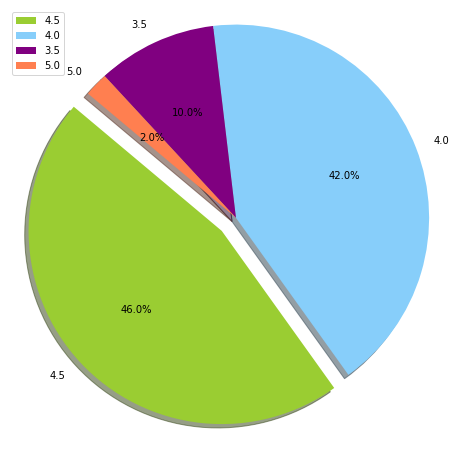

In [29]:
## pie chart can be made to find the percentage of each body-style
labels = list(df_final['ratings'].unique())
sizes = list(df_final['ratings'].value_counts())
colors = ['yellowgreen', 'lightskyblue', 'purple','coral']
explode = (0.1, 0, 0, 0)  # explode 1st slice
fig = plt.figure(figsize = (8,8)) 

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.legend(labels, loc="best")

plt.axis('equal')
plt.show()

C:\Users\manohar\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


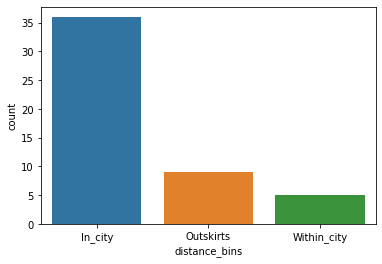

In [84]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.countplot(df_final['distance_bins']);

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('yelp_sf_14_10_2020.csv', encoding = "ISO-8859-1")

#convert price  into proper names
df.loc[df.price=='$','price']='cheap'
df.loc[df.price=='$$','price']='Moderate'
df.loc[df.price=='$$$','price']='expensive'

C:\Users\manohar\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


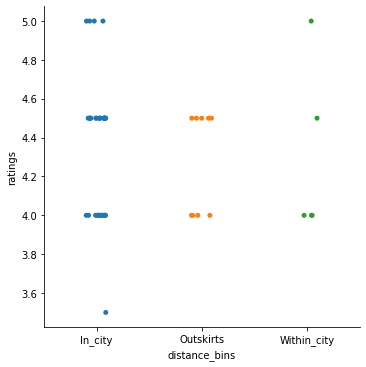

In [99]:
#To check how distancce and rating is related. from chart we can see lesser distance restuarnts have 
#higher rating as compare to outskirt which is because most of crowd dont like to travel
sns.catplot('distance_bins','ratings',data=df)

C:\Users\manohar\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='price', ylabel='distance'>

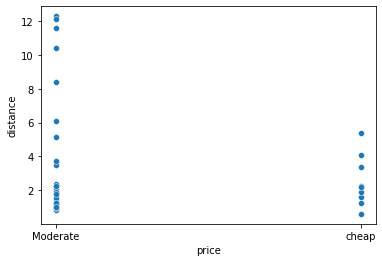

In [100]:
#to check how price and distance are related. from the chart we can see that lesser distance have cheap or moderate price while
# long distance restuarnts are expensive. this is because people go ocassionally for long drive and less no of option available
sns.scatterplot('price','distance',data=df)

<AxesSubplot:ylabel='review_count'>

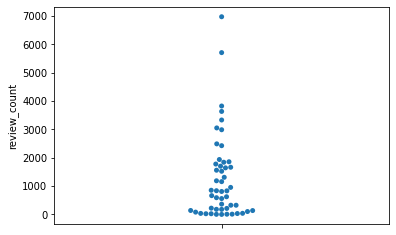

In [101]:
#To check how review count is distributed. from the chart we see there are some outlier otherwise it follows a certain range
sns.swarmplot(y=df.review_count)

<Figure size 1080x576 with 0 Axes>

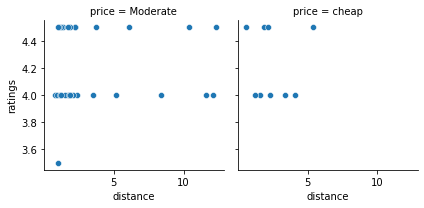

In [102]:
#how distance price and rating ar related altogether...
plt.figure(figsize=(15,8))
g = sns.FacetGrid(df, col="price")
g.map(sns.scatterplot, "distance","ratings")

(array([ 1.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0., 46.]),
 array([ 2. ,  3.8,  5.6,  7.4,  9.2, 11. , 12.8, 14.6, 16.4, 18.2, 20. ]),
 <BarContainer object of 10 artists>)

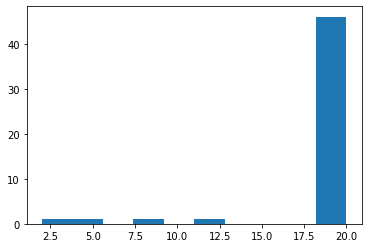

In [103]:
#get the frequency graph of review count
plt.hist(df.written_reviews_count)

C:\Users\manohar\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='review_count_bins', ylabel='ratings'>

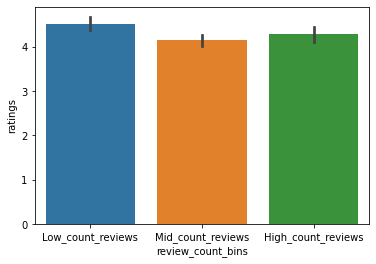

In [104]:
#to check how review count is related to rating 
sns.barplot(df.review_count_bins,df.ratings)

C:\Users\manohar\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='price', ylabel='ratings'>

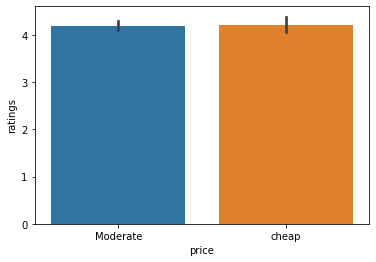

In [105]:
#relation between price and rating
sns.barplot(df.price,df.ratings)